In [1]:
from pathlib import Path
import os
os.chdir("..")

In [2]:
import lovely_tensors as lt
lt.monkey_patch()

In [3]:

import pickle
from einops import rearrange
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from PIL import Image
from torchmetrics import F1Score, MetricCollection
from torchvision.transforms.functional import resize

import numpy as np
import torch

from ffss.utils.utils import ResultDict, StrEnum, torch_dict_load, torch_dict_save, to_device
from ffss.models import build_model
from ffss.data import get_preprocessing, get_testloaders
from ffss.data.utils import (
    AnnFileKeys,
    PromptType,
    BatchKeys,
)
from ffss.substitution import Substitutor
from ffss.demo.visualize import (
    crop_seg,
    draw_all,
    draw_masks,
    feature_map_pca_heatmap,
    get_image,
    plot_seg,
)

In [80]:
def create_rgb_segmentation(segmentation, num_classes=None):
    """
    Convert a segmentation map to an RGB visualization using a precise colormap.

    Args:
        segmentation (torch.Tensor): Segmentation map of shape [B, H, W] where
                                      each pixel contains class labels (natural numbers).
        num_classes (int): The number of unique classes in the segmentation.

    Returns:
        torch.Tensor: RGB visualization of shape [B, 3, H, W].
    """
    if len(segmentation.shape) == 4:
        segmentation = segmentation.argmax(dim=1)
    if num_classes is None:
        num_classes = segmentation.max().item() + 1
    
    # Define a precise colormap for specific classes
    colormap = torch.tensor([
        [0, 0, 0],       # Class 0: Black (Background)
        [128, 0, 0],     # Class 1: Red
        [0, 128, 0],     # Class 2: Green
        [128, 128, 0],   # Class 3: Yellow
        [0, 0, 128],     # Class 4: Blue
        [128, 0, 128],   # Class 5: Magenta
        [0, 128, 128],   # Class 6: Cyan
        [192, 192, 192], # Class 7: Light Gray
    ], dtype=torch.uint8)  # Ensure dtype is uint8

    # Initialize an empty tensor for RGB output
    B, H, W = segmentation.shape
    rgb_segmentation = torch.zeros((B, 3, H, W), dtype=torch.uint8)

    # Loop through each class and assign the corresponding RGB color
    for class_id in range(num_classes):
        # Create a mask for the current class
        class_mask = (segmentation == class_id).unsqueeze(1)  # Shape: [B, 1, H, W]
        # Assign the corresponding color to the rgb_segmentation
        rgb_segmentation += class_mask * colormap[class_id].view(1, 3, 1, 1)  # Broadcasting

    return rgb_segmentation

def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Unnormalize a tensor image with mean and standard deviation.
    
    Args:
        tensor (torch.Tensor): Tensor image of size [B, 3, H, W] to be unnormalized.
        mean (list or tuple): Mean for each channel.
        std (list or tuple): Standard deviation for each channel.
    
    Returns:
        torch.Tensor: Unnormalized tensor image.
    """
    # Ensure the mean and std are tensors and have the correct shape
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device).view(1, 3, 1, 1)
    
    # Unnormalize the tensor
    tensor = tensor * std + mean
    
    return tensor

In [4]:
parameters = {
    'dataloader': {'num_workers': 0}, 
    'dataset': {
        'preprocess': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'image_size': 400},
        'datasets': {
            'test_weedmap': {
                'train_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/000',
                'test_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/003',
                'prompt_images': [
                    # 'frame0009_2.png',
                    'frame0021_2.png',
                    'frame0033_3.png',
                    'frame0034_1.png',
                    'frame0048_0.png',
                    ],
                'remove_black_images': False}
            },
    },
    'model': {
        'name': 'dmtnet',
        'model_checkpoint': 'checkpoints/dmtnet.pt',
        }, 
    'refinement': {'lr': 0.01, 'max_iterations': 1000}
}

In [5]:
def exg_refine(image, threshold, prediction):
    img = resize(image, prediction.shape[-2:])
    exg = 2*img[:, 1] - img[:, 0] + img[:, 2]
    exg_mask = ((exg - exg.min())/(exg.max() - exg.min()) > threshold)
    return (exg_mask*prediction) 


In [6]:
preprocess = get_preprocessing(parameters["dataset"])

### Get WeedMap

In [7]:
test_loaders = get_testloaders(
        parameters["dataset"],
        parameters["dataloader"]
    )
weedmap = test_loaders["test_weedmap"]

In [8]:
class FocalLoss(nn.Module):
    def __init__(
        self, gamma: float = 2.0, weights=None
    ):
        super().__init__()
        self.gamma = gamma
        self.weights = weights

        self.reduction = torch.mean

    def __call__(self, x, target):
        ce_loss = F.cross_entropy(x, target, reduction="none")
        pt = torch.exp(-ce_loss)
        
        if self.weights is not None:
            weights = self.weights.to(x.device)[target]
            focal_loss = torch.pow((1 - pt), self.gamma) * weights * ce_loss
        else:
            focal_loss = torch.pow((1 - pt), self.gamma) * ce_loss

        return self.reduction(focal_loss)

### Get Model

In [9]:
device = "cuda"
model = build_model(parameters["model"])
model.to(device)
model.eval()

DMTNetMultiClass(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


### Get the training data

In [10]:
examples = weedmap.dataset.extract_prompts()
examples = to_device(examples, device)

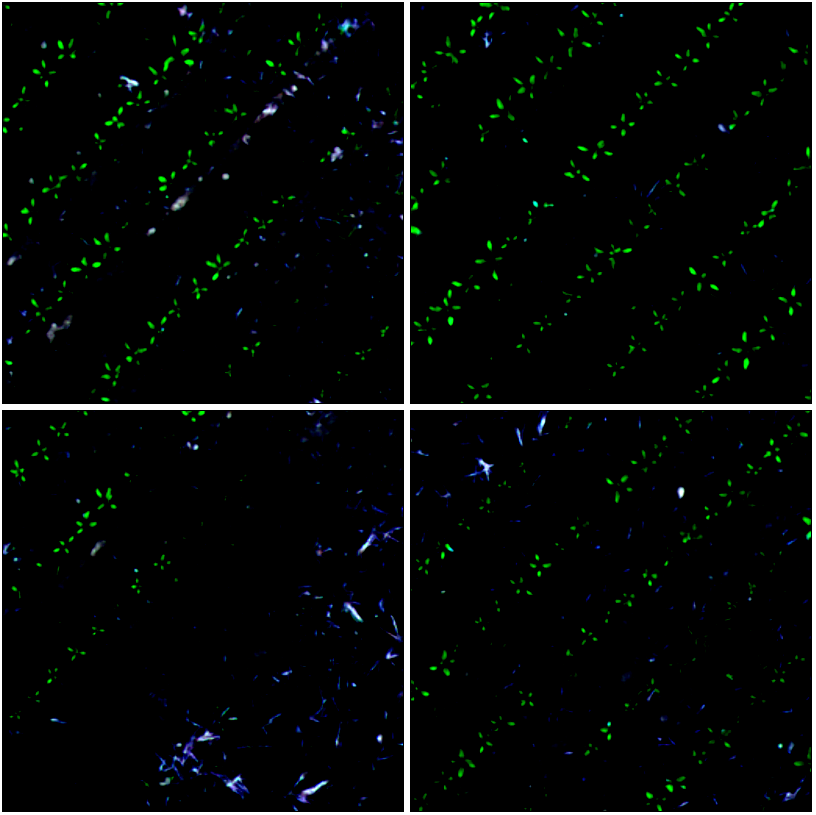

In [11]:
examples[BatchKeys.IMAGES].rgb

In [67]:
metrics = MetricCollection(
    metrics=[
            F1Score(
                task="multiclass",
                num_classes=weedmap.dataset.num_classes,
                average="none",
            )
    ]
).to(device)

In [13]:
lr = 1.e-3
max_iterations = 5000

hot_parameters = [
    # "model.conv1",
    # "model.conv2",
    # "model.conv3",
    # "model.mixer1",
    # "model.mixer2",
    # "model.mixer3",
]
train_backbone = False

if hot_parameters:
    for name, param in model.named_parameters():
        if any([
            hot_parameter in name
            for hot_parameter in hot_parameters
        ]):
            param.requires_grad = True
        else:
            param.requires_grad = False
for name, param in model.backbone.named_parameters():
    if train_backbone:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Training {name}")
        
support_gt = examples[BatchKeys.PROMPT_MASKS].argmax(dim=1).unsqueeze(0)

support_batch = {
    BatchKeys.IMAGES: examples[BatchKeys.IMAGES].unsqueeze(0),
    BatchKeys.PROMPT_MASKS: examples[BatchKeys.PROMPT_MASKS].unsqueeze(0),
    BatchKeys.FLAG_MASKS: examples[BatchKeys.FLAG_MASKS].unsqueeze(0),
    BatchKeys.FLAG_EXAMPLES: examples[BatchKeys.FLAG_EXAMPLES].unsqueeze(0),
    BatchKeys.DIMS: examples[BatchKeys.DIMS].unsqueeze(0)
}

_, class_counts = support_gt.unique(return_counts=True)
loss_weights = class_counts.sum() / (2*class_counts)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# loss_fn = nn.CrossEntropyLoss(weight=loss_weights)
loss_fn = FocalLoss()

Training reference_layer3.weight
Training reference_layer3.bias
Training reference_layer2.weight
Training reference_layer2.bias
Training reference_layer1.weight
Training reference_layer1.bias
Training reference_layer6.weight
Training reference_layer6.bias
Training reference_layer5.weight
Training reference_layer5.bias
Training reference_layer4.weight
Training reference_layer4.bias
Training hpn_learner.encoder_layer4.0.conv1.weight
Training hpn_learner.encoder_layer4.0.conv1.bias
Training hpn_learner.encoder_layer4.0.conv2.weight
Training hpn_learner.encoder_layer4.0.conv2.bias
Training hpn_learner.encoder_layer4.1.weight
Training hpn_learner.encoder_layer4.1.bias
Training hpn_learner.encoder_layer4.3.conv1.weight
Training hpn_learner.encoder_layer4.3.conv1.bias
Training hpn_learner.encoder_layer4.3.conv2.weight
Training hpn_learner.encoder_layer4.3.conv2.bias
Training hpn_learner.encoder_layer4.4.weight
Training hpn_learner.encoder_layer4.4.bias
Training hpn_learner.encoder_layer4.6.co

In [18]:
substitutor = Substitutor(substitute=True, subsample=1)
support_set_len = support_batch[BatchKeys.IMAGES].shape[1]
metrics.reset()

loss_total = 0
substitutor.reset(batch=(support_batch, support_gt))
for batch, gt in substitutor:
    with torch.no_grad():
        result = model(batch)
    logits = result[ResultDict.LOGITS]
    metrics.update(logits.argmax(dim=1), gt)
metric_values = metrics.compute()
print("Train metrics: ", metric_values)

Train metrics:  {'MulticlassF1Score': tensor cuda:0 0.781}


In [15]:
substitutor = Substitutor(substitute=True, subsample=1)
support_set_len = support_batch[BatchKeys.IMAGES].shape[1]
metric_update = 5
metrics.reset()

for i in range(max_iterations):
    loss_total = 0
    substitutor.reset(batch=(support_batch, support_gt))
    metrics.reset()
    for batch, gt in substitutor:
        result = model(batch)
        logits = result[ResultDict.LOGITS]
        loss_value = loss_fn(logits, gt) / support_set_len
        loss_value.backward()
        loss_total += loss_value.item()
        metrics.update(logits.argmax(dim=1), gt)
    if i % metric_update == 0:
        metric_values = metrics.compute()
        print(f"Iteration {i} {loss_value.item()}, Metrics {metric_values}")
    else:
        print(f"Iteration {i} {loss_value.item()}")
    optimizer.step()
    optimizer.zero_grad()

Iteration 0 0.05996023118495941, Metrics {'MulticlassF1Score': tensor cuda:0 0.333}
Iteration 1 0.050328634679317474
Iteration 2 0.04883876442909241
Iteration 3 0.04890046641230583
Iteration 4 0.04865873605012894
Iteration 5 0.04882832616567612, Metrics {'MulticlassF1Score': tensor cuda:0 0.314}
Iteration 6 0.04873596876859665
Iteration 7 0.04881838709115982
Iteration 8 0.04877398908138275
Iteration 9 0.048816531896591187
Iteration 10 0.04878929629921913, Metrics {'MulticlassF1Score': tensor cuda:0 0.314}
Iteration 11 0.04881609231233597
Iteration 12 0.04879610240459442
Iteration 13 0.04881597310304642
Iteration 14 0.04879901930689812
Iteration 15 0.048815928399562836, Metrics {'MulticlassF1Score': tensor cuda:0 0.314}
Iteration 16 0.048799630254507065
Iteration 17 0.04881591349840164
Iteration 18 0.048798397183418274
Iteration 19 0.048815906047821045
Iteration 20 0.04879489541053772, Metrics {'MulticlassF1Score': tensor cuda:0 0.314}
Iteration 21 0.048815906047821045
Iteration 22 0.04

In [27]:
substitutor.reset(batch=(support_batch, support_gt))

In [28]:
batch, gt = next(substitutor)

In [29]:
with torch.no_grad():
    result = model(batch)
    logits = result[ResultDict.LOGITS]

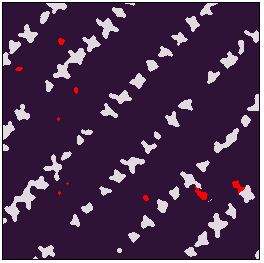

In [30]:
gt.chans

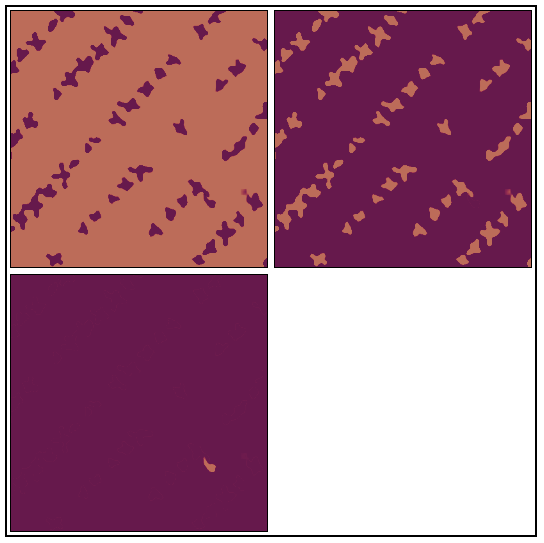

In [31]:
F.softmax(logits, dim=1).chans

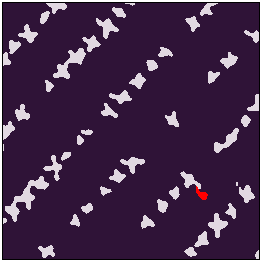

In [32]:
prediction = logits.argmax(dim=1)
prediction.chans

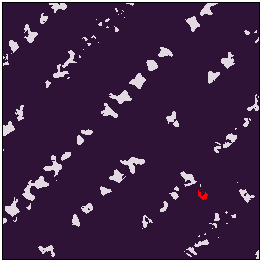

In [33]:
exg_refine(batch[BatchKeys.IMAGES][:, 0], 0.20, prediction).chans

### Test everything

In [34]:
from copy import deepcopy

def merge_dicts(prompts, imgs):
    device = imgs[BatchKeys.IMAGES].device
    merge_prompts = deepcopy(prompts)
    out = {}
    for k in set(list(imgs.keys()) + list(merge_prompts.keys())):
        if k in imgs and prompts:
            dim = 0
            if k == BatchKeys.IMAGES:
                merge_prompts[k] = merge_prompts[k].unsqueeze(dim=0)
                dim = 1
            out[k] = torch.cat([imgs[k].cpu(), merge_prompts[k].cpu()], dim=dim).to(
                device
            )
            if k == BatchKeys.DIMS:
                out[k] = out[k].unsqueeze(dim=0).to(device)
        elif k in imgs:
            out[k] = imgs[k].to(device)
        else:
            out[k] = merge_prompts[k].unsqueeze(dim=0).to(device)
    return out

In [43]:
from tqdm import tqdm

metrics.reset()
refined_metrics = metrics.clone()
bar = tqdm(
    enumerate(weedmap),
    total=len(weedmap),
    postfix={"loss": 0},
    desc="Test: ",
)
update_frequency = 10
with torch.no_grad():
    for batch_idx, batch_dict in bar:
        image_dict, gt = batch_dict
        input_dict = to_device(merge_dicts(prompts=cut_examples, imgs=image_dict), device)
        gt = to_device(gt, device)
        outputs = model(input_dict)[ResultDict.LOGITS]
        outputs = torch.argmax(outputs, dim=1)
        dims = image_dict[BatchKeys.DIMS][0].tolist()
        outputs = outputs[:, : dims[0], : dims[1]]
        refined_outputs = exg_refine(input_dict[BatchKeys.IMAGES][:, 0], 0.20, outputs)
        metrics.update(outputs, gt)
        refined_metrics.update(refined_outputs, gt)
        if batch_idx % update_frequency == 0:
            metrics_values = metrics.compute()
            bar.set_postfix({k: v.item() for k, v in metrics_values.items()})
    metrics_values = metrics.compute()
    refined_metrics_values = refined_metrics.compute()

    for k, v in metrics_values.items():
        print(f"Test - {k}: {v}")
    for k, v in refined_metrics_values.items():
        print(f"Refined Test - {k}: {v}")

Test: 100%|██████████| 408/408 [02:37<00:00,  2.59it/s, MulticlassF1Score=0.336]

Test - MulticlassF1Score: 0.3360520005226135
Refined Test - MulticlassF1Score: 0.3481042683124542


In [36]:
iterator = iter(weedmap)

In [68]:
batch_dict  = next(iterator)

In [69]:
cut_examples = {k: v[:1] for k, v in examples.items()}

{'MulticlassF1Score': tensor[3] x∈[0., 0.910] μ=0.328 σ=0.506 cuda:0 [0.910, 0.073, 0.]}


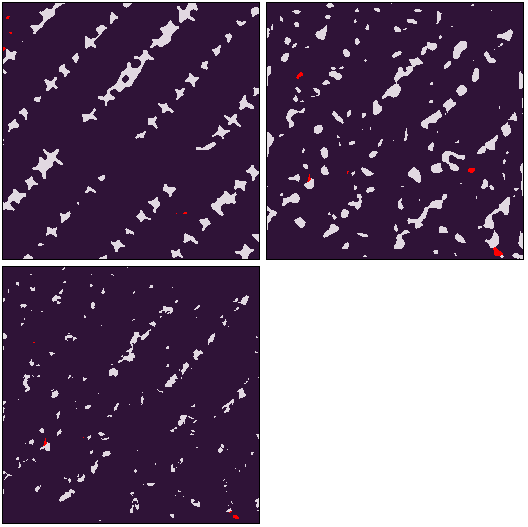

In [70]:
image_dict, gt = batch_dict
metrics.reset()
input_dict = to_device(merge_dicts(prompts=cut_examples, imgs=image_dict), device)
gt = to_device(gt, device)
outputs = model(input_dict)[ResultDict.LOGITS]
outputs = torch.argmax(outputs, dim=1)

refined = exg_refine(input_dict[BatchKeys.IMAGES][:, 0], 0.20, outputs)
print(metrics(outputs, gt))
torch.cat([gt, outputs, refined], dim=0).chans

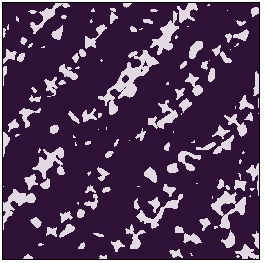

In [74]:
((outputs == 1) + (gt == 1)).chans

In [76]:
create_rgb_segmentation(outputs)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

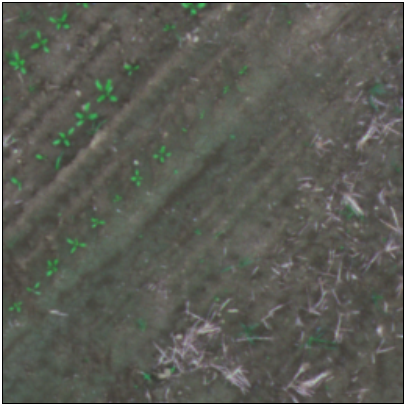

In [82]:
unnormalize(batch["images"][:, 0]).rgb

In [87]:
create_rgb_segmentation(gt.cpu()) * 0.2 + unnormalize(batch["images"][:, 0]) * 0.8

RuntimeError: The size of tensor a (256) must match the size of tensor b (400) at non-singleton dimension 3